# Example X: Modelling with PyTracerLab in the Bayesian Statistical Framework
Here we show how to use the PyTracerLab package to perform a basic standard application of lumped parameter models (see Examples 1 and 2), but using another synthetically generated dataset. As in Example 2, we stay in a Bayesian statistical framework using a Markov-chain Monte Carlo sampler. The data, however, is not generated with a Lumped Parameter Model anymore - so we don't expect our model to match the data perfectly and we don't expect our model to recover some "true" parameters. We still know the process that generated the data but this process is not parameterized in the same way as our Lumped Parameter Models; it is a moderately complex MODFLOW model. The observations we consider here reflect average tracer concentration in river water. Tracer enters the system via recharge (bell-shaped pulse over a 50-year period, similar to the real tritium input) and has the same decay coefficient as tritium. Tracer-free water also enters the system via an infiltration well.

## Conceptualizing the Problem for LPMs
We know that there is an infiltration well in our system that supplies tracer-free water. We can model such a contribution by adding a model unit that has a fixed, very large mean residence time (e.g., 500 years). We even know the flow rate with which the well infiltrates water - but we do not know the fraction of well water in river water. So we have to consider a model with at least two components: one component represent the tracer-free well water, the other component represents the actual system. Because we do not know the mixing ratio of the components, we have to consider several different scenarios of mixing ratios.

In [1]:
import PyTracerLab.model as ism
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

## 1. Load (Synthetic) Observation Data
See the PyTracerLab Paper on how this data is generated. The data generating model is described in more detail in [Rudolph et al. (2025)](https://doi.org/10.1029/2025WR041972).

In [2]:
# load input series
# this would be the tracer concentration in precipitation or recharge in a
# practical problem
file_name = "input_monthly_modflow.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
input_series = np.array([float(row[1]) for row in data])

# load observation series
# this would be the measured tracer concentration in groudnwater in a
# practical problem
file_name = "obs_monthly_modflow.csv"
data = np.genfromtxt(
    file_name,
    delimiter=",",
    dtype=["<U7", float],
    encoding="utf-8",
    skip_header=1
)

timestamps = np.array([datetime.strptime(row[0], r"%Y-%m") for row in data])
obs_series = np.array([float(row[1]) for row in data])

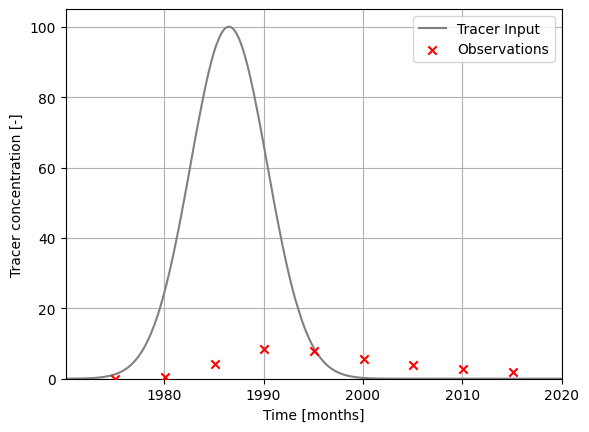

In [3]:
### plot input series, output series, and observations

# get observation timesteps
timesteps = [t.year + t.month / 12.0 for t in timestamps]

# create figure
fig, ax = plt.subplots(1, 1)
# plot input series
ax.plot(
    timesteps,
    input_series,
    label="Tracer Input",
    c="grey"
)
# plot observations
ax.scatter(
    timesteps,
    obs_series,
    label="Observations",
    color="red",
    marker="x",
    zorder=10
)
ax.set_xlim(timesteps[0], timesteps[-1])
ax.set_ylim(0.0, 105.)
ax.set_xlabel("Time [months]")
ax.set_ylabel("Tracer concentration [-]")
ax.legend()
ax.grid()
plt.show()

## 2. Set up Models, Run MCMC for Model Parameters

In [4]:
def run_mixing_fraction(em_fraction):
    t_half = 12.3 * 12.0
    lambda_ = np.log(2.0) / t_half

    ### define model (use the same structure / units as the true model)
    # time step is 1 month
    m = ism.Model(
        dt=1.0,
        lambda_=lambda_,
        input_series=input_series,
        target_series=obs_series,
        steady_state_input=None,
        n_warmup_half_lives=2
    )

    # add an exponential-piston-flow unit
    # define the initial model parameters for inference
    em_mtt_init = 12 * 2 # 1 year

    m.add_unit(
        ism.EMUnit(mtt=em_mtt_init),
        fraction=em_fraction, # fraciton of the overall response
        bounds=[(12. * 0.5, 12.0 * 1000.)],
        prefix="em"
    )

    # add an exponential-piston-flow unit
    # define the initial model parameters for inference
    pm_mtt_init = 12 * 500 # 500 years, tracer-free water
    m.add_unit(
        ism.PMUnit(mtt=pm_mtt_init),
        fraction=1 - em_fraction, # 100 percent of the overall response
        bounds=[(12. * 0.5, 12.0 * 1000.)],
        prefix="pm"
    )

    # fix mtt of pm
    m.set_fixed("pm.mtt")

    # create a solver
    solver = ism.Solver(m)
    # run DREAM
    res = solver.dream_sample(
        n_samples=2000, # effective samples after burn-in and thinning
        burn_in=3000,
        thin=1,
        n_chains=3,
        n_diff_pairs=1,
        cr=[i / 10 for i in range(1, 11)],
        gamma_jitter=0.2,
        jitter=1.e-5,
        sigma=1.,
        random_state=123456,
        return_sim=True,
        set_model_state=False
    )

    # plot chains to inspect convergence
    fig, ax = plt.subplots(res["samples_chain"].shape[2], 1, figsize=(6, res["samples_chain"].shape[2] * 1.5), sharex=True)

    ax = np.atleast_1d(ax)

    for i in range(res["samples_chain"].shape[2]):
        for j in range(res["samples_chain"].shape[0]):
            ax[i].plot(res["samples_chain"][j, :, i] / 12., c="k", lw=.5, alpha=0.4)
        ax[i].set_ylabel(m.param_keys(free_only=True)[i])
        ax[i].set_xlim(0, res["samples_chain"].shape[1])
    ax[-1].set_xlabel("Steps")

    # print gelman rubin convergence statistics
    print(res["gelman_rubin"])

    # get travel time distributions
    step_limit = 12 * 1000
    # iterate over samples
    age_dists = []
    samples = res["samples"]
    # get random subset
    samples = samples[np.random.choice(samples.shape[0], 2000, replace=True)]
    for sample in res["samples"]:
        # set model parameters
        for item in zip(m.param_keys(free_only=True), sample):
            m.set_param(key=item[0], value=item[1])
        # get age distribution
        age_distributions = m.get_age_distributions(n_steps=step_limit)
        age_dists.append(
            age_distributions["fractions"][0] * age_distributions["distributions"][0] + \
            age_distributions["fractions"][1] * age_distributions["distributions"][1]
        )

    return res, age_dists, m

{'em.mtt': 1.0201976078942565}
{'em.mtt': 1.0094327270855767}
{'em.mtt': 1.0101495626623}


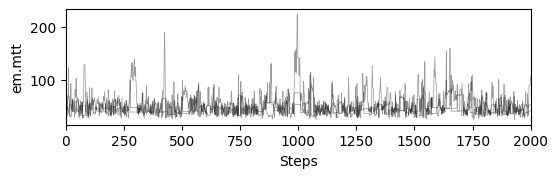

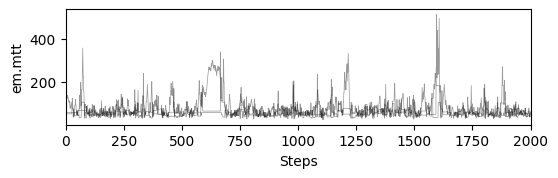

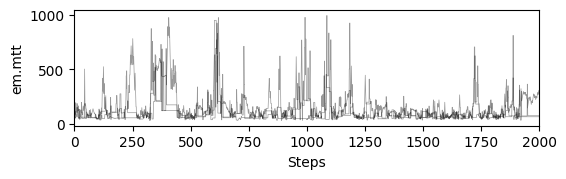

In [5]:
results, age_distributions, models = [], [], []

mixing_ratios = np.linspace(.45, .5, 3) # np.linspace(.1, .9, 9)

for em_fraction in mixing_ratios:
    r_, a_, m_ = run_mixing_fraction(em_fraction)
    results.append(r_)
    age_distributions.append(a_)
    models.append(m_)

In [6]:
def nse(obs, sim):
    obs_ = obs.reshape(-1, 1)
    sim_ = sim.reshape(-1, 1)
    mask = ~np.isnan(obs_) & ~np.isnan(sim_)
    resid = sim_ - obs_
    dev = obs_ - np.nanmean(obs_)
    nse_ = 1 - np.sum(resid[mask] ** 2) / np.sum(dev[mask] ** 2)
    return nse_

In [7]:
# load modflow travel times from csv
tts_mf = pd.read_csv("tts_weights_modflow.csv", index_col=None)
tts_mf.head()

tts   weights
0  1799.8800  0.000344
1  1799.8800  0.000344
2  1799.8800  0.000344
3  1799.8800  0.000344
4   580.1829  0.000344

0.4492897048732825 0.0029693625434188305
0.4703132131655416 0.014792317275676025
0.47598616511950875 0.04586896266719221


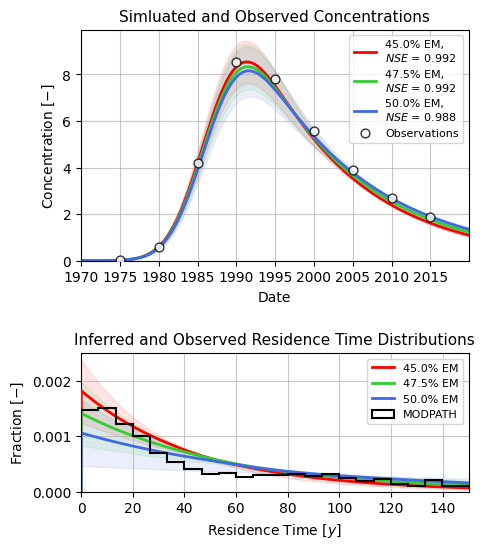

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(5, 6),
                       gridspec_kw={"height_ratios": [2, 1.2], "hspace": .5, "wspace": .1},
                       sharey="row", sharex="row")

start = 0
end = 900

colors = ["red", "limegreen", "royalblue", "darkorange", "black"]

for i in range(len(results)):
    # plot ssimulations
    sim_data = results[i]["sims"]
    s = sim_data.reshape((-1, sim_data.shape[-1]))
    q = np.quantile(s, [0.1, 0.5, 0.9], axis=0)

    ax[0].plot(
        timestamps[start:end],
        q[1, start:end],
        c=colors[i],
        ls="-",
        lw=2.,
        label=fr"{mixing_ratios[i] * 100:.1f}% EM, " + "\n" + \
            fr"$ NSE $ = {nse(obs_series[start:end], q[1, start:end]):.3f}"
    )
    ax[0].fill_between(
        timestamps[start:end],
        q[0, start:end], q[2, start:end],
        color=colors[i],
        alpha=0.1,
    )

    # plot age distributions
    step_limit = 12 * 400
    dt = 1.

    # integrate age distributions to check area integrates to 1
    # use trapezoidal rule
    integrals = []
    age_dists_ = []
    for j in range(len(age_distributions[i])):
        I = np.trapezoid(age_distributions[i][j][:step_limit], dx=dt)
        age_dists_.append(age_distributions[i][j][:step_limit] / I)
        integrals.append(I)
    print(np.mean(integrals), np.std(integrals))

    t_plot = np.arange(0, step_limit * dt, dt) # years
    ax[1].plot(
        t_plot, 
        np.median(age_dists_, axis=0),
        alpha=1.,
        c=colors[i],
        lw=2.,
        ls="-",
        zorder=10,
        label=fr"{mixing_ratios[i] * 100:.1f}% EM"
    )
    ax[1].fill_between(
        t_plot, 
        np.quantile(age_dists_, 0.9, axis=0),
        np.quantile(age_dists_, 0.1, axis=0),
        alpha=.1,
        color=colors[i]
    )

ax[0].scatter(
    timestamps, obs_series,
    marker="o", facecolor="w",
    edgecolor="k", s=40,
    zorder=100, alpha=0.8,
    lw=1., label="Observations"
)
ax[0].legend(fontsize=8)
ax[0].grid(alpha=0.7)
ax[0].set_xlim(timestamps[0], timestamps[-1])
ax[0].set_ylim(0)
ax[0].set_xlabel("Date")
ax[0].set_ylabel(r"Concentration $ [-] $")
ax[0].set_title("Simluated and Observed Concentrations", fontsize=11)

_ = ax[1].hist(
    tts_mf["tts"] / 30.,
    weights=tts_mf["weights"],
    bins=100,
    color="k",
    alpha=1.,
    zorder=1000,
    density=True,
    histtype="step",
    lw=1.5, ls="-",
    label="MODPATH"
)

# the xticks of the age distribution plot are in months
# we want them in years
xmax = 12 * 150 # 250 years
step_years = 20
ax[1].legend(fontsize=8)
ax[1].set_xticks(np.arange(0, xmax, 12 * step_years))
ax[1].set_xticklabels(np.arange(0, xmax / 12, step_years, int))
ax[1].set_xlim(0, xmax)
ax[1].grid(alpha=0.7)
ax[1].set_xlabel(r"Residence Time $ [y] $")
ax[1].set_ylabel(r"Fraction $ [-] $")
ax[1].set_title("Inferred and Observed Residence Time Distributions", fontsize=11)

plt.savefig("modflow_PyTracerLab.png", dpi=600, bbox_inches="tight")